In [1]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
import orbithunter as orb
import inspect
import orbithunter.ks as ks
import h5py
import time
from matplotlib import gridspec
import pandas as pd

# Investigation into spacetime coverings

<a id='func'></a>
# A. Function declarations.
Some of these are deprecated; work in progress

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, widgets
# import plotly.graph_objs as go
import plotly.offline as py
import chart_studio.plotly as plotly
import seaborn as sns
import mpl_toolkits.mplot3d.art3d as art3d
from plotly.graph_objects import *
import matplotlib.pyplot as plt 
from matplotlib import gridspec

invert=True
def interactwrapper(orbit_cover_instance, trimmed_scores=None, mapped_scores=None, **kwargs):
    mindex = kwargs.get('mindex', 0)
    maxdex = kwargs.get('maxdex', len(orbit_cover_instance.windows)-1)
    windows = orbit_cover_instance.windows
    if trimmed_scores is None:
        trimmed_scores = orbit_cover_instance.trim()
    if mapped_scores is None:
        mapped_scores = orbit_cover_instance.map()
        

    def update(orbit_index):
        nonlocal trimmed_scores
        nonlocal mapped_scores
        nonlocal windows
        scores = trimmed_scores[orbit_index]
        vmin = scores.min()
        if scores[scores!=np.inf].size != 0:
            vmax = scores[scores!=np.inf].max()
        else:
            vmax = vmin
        fig = plt.figure(figsize=(20,20)) 
        gs = gridspec.GridSpec(3, 3, width_ratios=[20, 1, 20], height_ratios=[20, 1, 20]) 

        ax0 = plt.subplot(gs[:, 0])
        ax1 = plt.subplot(gs[:, 1])    
        ax2 = plt.subplot(gs[:, 2])
        ax1.imshow(windows[orbit_index].state, cmap='jet')

        invalid_masked = np.ma.masked_invalid(mapped_scores[orbit_index])
        masked_base = np.ma.masked_array(orbit_cover_instance.base.state, mask=invalid_masked.mask)
        im1 = ax0.imshow(scores, vmin=vmin, vmax=vmax, cmap='viridis', interpolation='none')
        im2 = ax2.imshow(masked_base, cmap='jet', interpolation='none')
        ax1.axis('off')
        ax0.set_xticklabels('')
        ax0.set_yticklabels('')
        ax2.set_xticklabels('')
        ax2.set_yticklabels('')
        fig.colorbar(im2, ax=ax2, shrink=0.3)
        fig.colorbar(im1, ax=ax0, shrink=0.3)
        plt.show()
    interact(update, orbit_index=widgets.IntSlider(min=mindex, max=maxdex, step=1, value=0));

<a id='glossary'></a>
# B. Glossary.


**Covering orbits** : The set of orbits whose shadowing constitutes the cover. 

**Cover** : The regions of space-time detected as shadowing of a set of periodic orbits, called the covering orbits.

**Minimal covering orbits** : A subset of the covering orbits which reproduces a certain proportion of the cover. 

**Minimal cover**: The space-time shadowed by the orbits in the minimal covering set. 

**Family**: A collection of orbits which are all related by continuation

**Group orbit**: The collection of equivariant orbits populated by applying symmetry operations to a single orbit, i.e. a single representative of a family. 

**[Return to table of contents](#toc)**

<a id='intro'></a>
# Introduction

With the results from investigations into continuation, continuous families, scoring statistics we can begin to test the covering process. We want to try to cover spacetime with the smallest number of orbits as possible; therefore, the first main objective before beginning the full covering computations (i.e. determining the area proportions and statistical averages across infinite spacetime) is to first determine how stingy we can be with the sampling of continuous families and group orbits of different fundamental orbits. 

We should also determine a good metric to use for the detection of orbit shadowing, but for now we'll use $L_2$ distance, with a local Galilean velocity (mean flow) correction. It is also important to 

<a id='families'></a>
# Dependence on continuous tile family members

First, use the covering algorithm with a collection of orbits generated by continuation in spatial domain size. 

In [3]:
large_patch = orb.read_h5('./data/large_patch.h5', '0/')

In [4]:
with h5py.File('fpo_thresholds.h5', 'r') as file:
    thresholds = [file['defect'][...],
                  file['drifter'][...],
                  file['large_defect'][...],
                  file['wiggle'][...]]

In [5]:
defect_family = [x.transform(to='field') for x in orb.read_h5('./data/large_cover.h5', 'defect/')]

In [6]:
defect_family_cover = orb.OrbitCover(large_patch,
                         defect_family,
                         [thresholds[0]]*len(defect_family),
                         periodicity=(False, True),
                         replacement=False,
                         min_overlap = 1,
                        )

defect_family_cover_result = orb.cover(defect_family_cover, verbose=True)

----------

We start with 205 orbits, but find that only 5 can cover approximately 99% of the area and so we reduce to this number. In other words, covering is not very sensitive to which continuous family member to use. This is good, considering there are an infinite number of family members by definition.

In [7]:
defect_family_minimal_covering_set = defect_family_cover_result.minimal_covering_set(cover_threshold=0.99)
# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
trimmed = defect_family_minimal_covering_set.trim()
# Passing masked=False for map will take a good amount time, but it is possible. 
mapped = defect_family_minimal_covering_set.map()

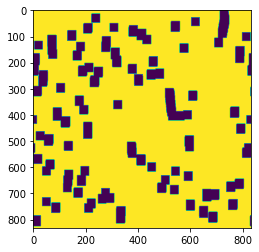

In [8]:
minmapped = mapped.min(axis=0)
plt.imshow(minmapped.mask.astype(int))

Proportion of spacetime covered by the collection of orbit continuations

In [9]:
np.invert(minmapped.mask).sum() / minmapped.size

0.17641832701553253

In [10]:
interactwrapper(defect_family_minimal_covering_set, trimmed_scores=trimmed, mapped_scores=mapped)

interactive(children=(IntSlider(value=0, description='orbit_index', max=4), Output()), _dom_classes=('widget-i…

### Dependence on group orbit members

Unlike the orbits spanned by continuation, the covering/shadowing is sensitive to which group orbit member you use. The reason is that the specific scoring metric is computed elementwise; therefore small, continuous deformations to the field values do not have nearly the same effect as discrete rotations. This can be seen by the fact that in order to cover 99% of the spacetime 
shadowed by the group orbit. 

In [11]:
windows = [x.transform(to='field') for x in orb.read_h5('./data/minimal_cover.h5')]
fundamental_windows = [list(x.group_orbit(fundamental_domain=True, rolls=(4, 4))) for x in windows[:1]]
window_thresholds = [len(f)*[t] for f, t in zip(fundamental_windows, thresholds)]
defect_group_orbit = fundamental_windows[0]
defect_group_orbit_thresholds = window_thresholds[0]

In [12]:
defect_group_orbit_cover = orb.OrbitCover(large_patch,
                     defect_group_orbit,
                     defect_group_orbit_thresholds,
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    )

In [13]:
t0ad=time.time_ns()/10**9
defect_group_orbit_cover_result = orb.cover(defect_group_orbit_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nCovering took {:.2f} seconds to complete'.format(t1ad-t0ad))

----------
Covering took 625.07 seconds to complete


In [14]:
defect_group_orbit_minimal_covering_set = defect_group_orbit_cover_result.minimal_covering_set(cover_threshold=0.99, verbose=False)

# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
trimmed = defect_group_orbit_minimal_covering_set.trim()
# Passing masked=False for map will take a good amount time, but it is possible. 
mapped = defect_group_orbit_minimal_covering_set.map()

interactwrapper(defect_group_orbit_minimal_covering_set, trimmed_scores=trimmed, mapped_scores=mapped)

interactive(children=(IntSlider(value=0, description='orbit_index', max=115), Output()), _dom_classes=('widget…

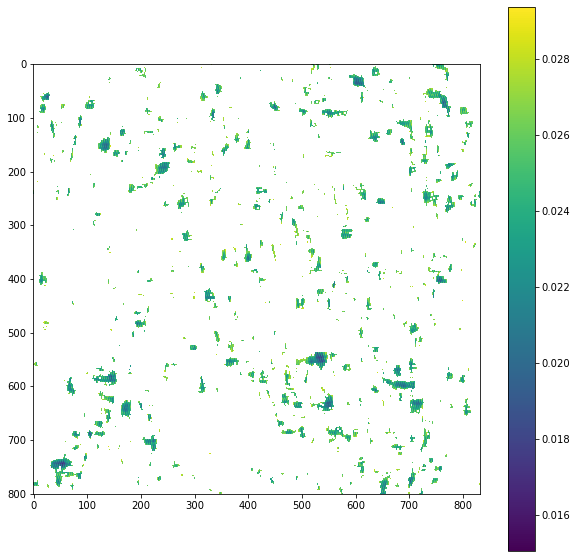

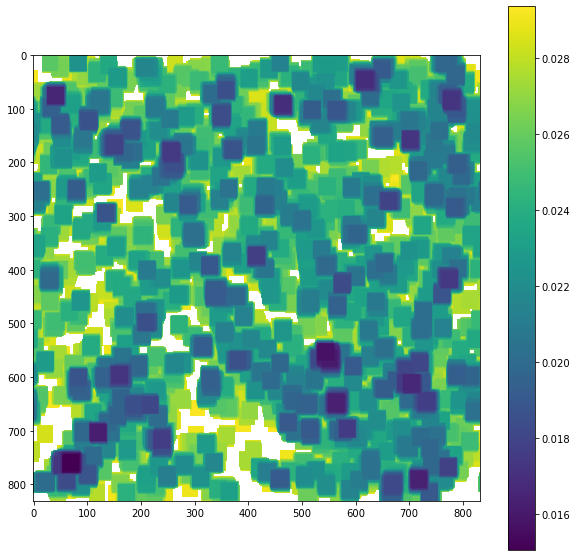

interactive(children=(IntSlider(value=0, description='orbit_index', max=115), Output()), _dom_classes=('widget…

In [15]:
# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
trimmed_go = defect_group_orbit_minimal_covering_set.trim()
# Passing masked=False for map will take a good amount time, but it is possible. 
mapped_go = defect_group_orbit_minimal_covering_set.map()

plt.figure(figsize=(10,10))
plt.imshow(trimmed_go.min(axis=0))
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(mapped_go.min(axis=0))
plt.colorbar()
plt.show()

interactwrapper(defect_group_orbit_minimal_covering_set, trimmed_scores=trimmed_go, mapped_scores=mapped_go)

In [69]:
def parallelipiped_map(coordinates, **kwargs):
    # Coordinates are (d, *orbit.shape) dimensional indices.
    # Only have to map "x" coordinates; those are the columns.
    x_indices = coordinates[1]
    t_indices = coordinates[0]
    shift = t_indices.shape[0]
    # use broadcasting by reshaping into n_components = size//shift
    shift_array_reshaped_for_broadcasting = np.arange(shift//2, -shift//2, -1).reshape(-1, 1)
    new_x =  (x_indices + shift_array_reshaped_for_broadcasting).reshape(1, -1)
    if kwargs.get('window', False):
        new_x = np.mod(new_x, x_indices.shape[1])
    return np.concatenate(((t_indices).reshape(1, -1), new_x))

In [56]:
defect_family_minimal_covering_set.windows = np.array([x.to_fundamental_domain() for x in 
                                                       defect_family_minimal_covering_set.windows])

In [57]:
t0ad=time.time_ns()/10**9
defect_family_minimal_covering_set.coordinate_map = parallelipiped_map
parallelipiped_family_cover_result = orb.cover(defect_family_minimal_covering_set, verbose=True)
t1ad=time.time_ns()/10**9
print('\nCovering took {:.2f} seconds to complete'.format(t1ad-t0ad))

---------
Covering took 180.57 seconds to complete


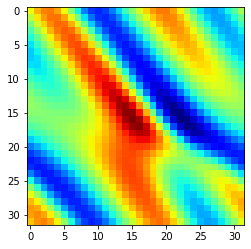

In [70]:
t, x = parallelipiped_map(np.indices((32,32)), window=True)
plt.imshow(windows[0].state[t, x].reshape(32,32), cmap='jet')

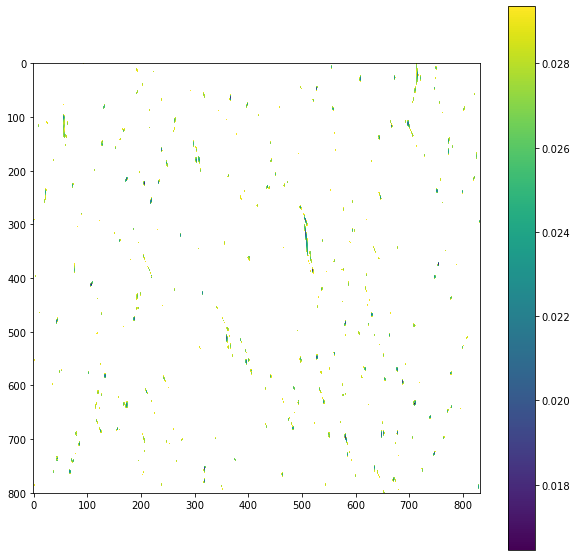

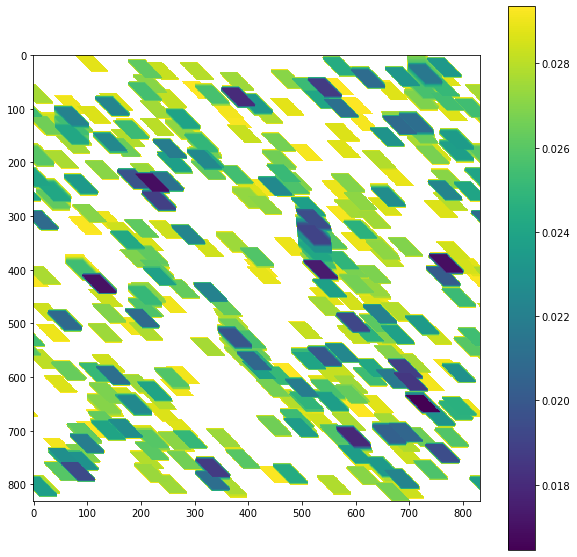

interactive(children=(IntSlider(value=0, description='orbit_index', max=4), Output()), _dom_classes=('widget-i…

In [59]:
# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
trimmed_para = parallelipiped_family_cover_result.trim()
# Passing masked=False for map will take a good amount time, but it is possible. 
mapped_para = parallelipiped_family_cover_result.map()

plt.figure(figsize=(10,10))
plt.imshow(trimmed_para.min(axis=0), interpolation='none')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(mapped_para.min(axis=0), interpolation='none')
plt.colorbar()
plt.show()

interactwrapper(parallelipiped_family_cover_result, trimmed_scores=trimmed_para, mapped_scores=mapped_para)